## Plot CRT On Board Survey frequency

```
OMX conversion Voyager syntax: 
CONVERTMAT FROM='skm_d8_Pk.mtx', TO='skm_d8_Pk.omx', FORMAT=OMX COMPRESSION=6
CONVERTMAT FROM='skm_d8_Ok.mtx', TO='skm_d8_Ok.omx', FORMAT=OMX COMPRESSION=6
CONVERTMAT FROM='skm_w8_Pk.mtx', TO='skm_w8_Pk.omx', FORMAT=OMX COMPRESSION=6
CONVERTMAT FROM='skm_w8_Ok.mtx', TO='skm_w8_Ok.omx', FORMAT=OMX COMPRESSION=6
```

In [1]:
import os
import pandas as pd
import numpy as np
import openmatrix as omx
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### Working Directory

model_dictionary = {
    "RTP v9.0" : r"\\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019",
    "TDM-Recalib": "../"
}

Model_path = 
model_data_loc = os.path.join(Model_path, r"4_ModeChoice\1a_Skims")
model_data_loc2 = os.path.join(Model_path, r"4_ModeChoice")


# in cube process these files:
# "2_DetailedTripMatrices\HBW_trips_allsegs_Pk.omx"
# "2_DetailedTripMatrices\HBO_trips_allsegs_Pk.omx"
# "2_DetailedTripMatrices\NHB_trips_allsegs_Pk.omx"
# "2_DetailedTripMatrices\HBC_trips_allsegs_Pk.omx"
# "2_DetailedTripMatrices\HBW_trips_allsegs_Ok.omx"
# "2_DetailedTripMatrices\HBO_trips_allsegs_Ok.omx"
# "2_DetailedTripMatrices\NHB_trips_allsegs_Ok.omx"

# and below
transit_skim_loc = [r"1a_Skims\skm_d8_Pk.omx", r"1a_Skims\skm_d8_Ok.omx", r"1a_Skims\skm_w8_Pk.omx", r"1a_Skims\skm_w8_Ok.omx"]


ivt_mtx = r"BY_2019\1a_Skims"

OBS_df = pd.read_csv(r"_data\2019 Final Weighted UTA OD Data - 2022-04-05 - processed.csv", low_memory=False)

# scenario to check the modeled TLFD
scenario = 'BY_2019'

In [6]:
CRTpkok=OBS_df[(OBS_df['Linked_Mode'] == 8)] # & (df['Ac_Mode_Model'] == 'Drive') & (df['PK_OK'].isin(['PK','OK']) )
columns = ['id','p_TAZID','a_TAZID','Ac_Mode_Model','PK_OK','linked_weight_adj','Veh_Cat3p','Purp5_text']
CRTpkok=CRTpkok[columns]
# Assign 2 to 'Veh_Cat3p' where the current value is 3
CRTpkok.loc[CRTpkok['Veh_Cat3p'] == 3, 'Veh_Cat3p'] = 2
### List of TAZs in model which are invalid
invalid_model_taz_list = np.arange(3547, 3601)

In [7]:
### Get CR travel time for each access mode and time period

# List of dictionary, combining all relevant info
transit_data = [
    {"skim_loc": "skm_d8_Pk.omx", "acc_mode": "Drive", "tp": "PK"},
    {"skim_loc": "skm_d8_Ok.omx", "acc_mode": "Drive", "tp": "OK"},
    {"skim_loc": "skm_w8_Pk.omx", "acc_mode": "Walk", "tp": "PK"},
    {"skim_loc": "skm_w8_Ok.omx", "acc_mode": "Walk", "tp": "OK"}
]

crtime_2019_dict = {}

# Loop through the list of dictionaries
for data in transit_data:
    # Read the transit skim file
    crtime_file = omx.open_file(os.path.join(model_data_loc, data["skim_loc"]))
    crtime_mtx = np.array(crtime_file['D8'])

    # Create DataFrame with proper columns
    crtime_df = pd.DataFrame(pd.DataFrame(crtime_mtx).stack()).reset_index().rename(
        {'level_0': 'p_TAZID', 'level_1': 'a_TAZID', 0: 'cr_travel_distance'}, axis=1)

    # Add additional info from the current dictionary
    crtime_df['Ac_Mode_Model'] = data["acc_mode"]
    crtime_df['PK_OK'] = data["tp"]

    # Store the result in the dictionary using a unique key
    crtime_2019_dict[f"{data['acc_mode']}_{data['tp']}"] = crtime_df.copy()
    print(data["skim_loc"], '\n', data["acc_mode"], '\n', data["tp"], '\n')



skm_d8_Pk.omx 
 Drive 
 PK 

skm_d8_Ok.omx 
 Drive 
 OK 

skm_w8_Pk.omx 
 Walk 
 PK 

skm_w8_Ok.omx 
 Walk 
 OK 



In [8]:
### Combine all CR travel times combinations
crtime_2019_df = pd.DataFrame(columns=['p_TAZID', 'a_TAZID', 'cr_travel_distance', 'Ac_Mode_Model', 'PK_OK'])
crtime_2019_df
for i in crtime_2019_dict.keys():
    crtime_2019_df = pd.concat([crtime_2019_df, crtime_2019_dict[i]], axis=0)

C:\Users\bhereth\AppData\Local\Temp\ipykernel_15288\4051453209.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crtime_2019_df = pd.concat([crtime_2019_df, crtime_2019_dict[i]], axis=0)


In [9]:
### Add CR time to OBS data
CRTpkok=CRTpkok[['p_TAZID', 'a_TAZID', 'Ac_Mode_Model', 'PK_OK','linked_weight_adj','Veh_Cat3p','Purp5_text']]
# Convert the columns 'p_TAZID' and 'a_TAZID' to integers (removing the decimal part)
CRTpkok['p_TAZID'] = CRTpkok['p_TAZID'].astype(int)
CRTpkok['a_TAZID'] = CRTpkok['a_TAZID'].astype(int)
crtime_2019_df['p_TAZID'] = crtime_2019_df['p_TAZID'].astype(int)
crtime_2019_df['a_TAZID'] = crtime_2019_df['a_TAZID'].astype(int)

print(CRTpkok.shape)
OBS_w_Time_df = pd.merge(CRTpkok, crtime_2019_df, on=['p_TAZID', 'a_TAZID', 'Ac_Mode_Model', 'PK_OK'], how='left')
print(OBS_w_Time_df.shape)

(2949, 7)
(2949, 8)


In [10]:
### Function to convert model trips and transfers to dataframe
def create_model_mtx_to_df(
        trips_file_name, 
        crtime_file_name, 
        trips_mtx_name, 
        crtime_mtx_name='D8', 
        cols=['p_taz', 'a_taz', 'trips_count', 'cr_travel_distance'], 
        remove_tazs=invalid_model_taz_list):
    trips_file = omx.open_file(trips_file_name)
    trips_mtx = np.array(trips_file[trips_mtx_name])
    crtime_file = omx.open_file(crtime_file_name)
    crtime_mtx = np.array(crtime_file[crtime_mtx_name])

    trips_df = pd.DataFrame(pd.DataFrame(trips_mtx).stack()).rename({0: cols[2]}, axis=1)
    crtime_df = pd.DataFrame(pd.DataFrame(crtime_mtx).stack()).rename({0: cols[3]}, axis=1)

    ### Merge both trips and transfers dataframes
    model_df = pd.concat([trips_df, crtime_df], axis=1).reset_index().rename({'level_0': cols[0], 'level_1': cols[1]}, axis=1)
    
    ### Remove invalid TAZs from prod and attr
    model_df[cols[0]] += 1
    model_df[cols[1]] += 1
    model_df = model_df[~model_df[cols[0]].isin(remove_tazs) & ~model_df[cols[1]].isin(remove_tazs)]


    return model_df

Processing Scenario:
HBW PK dCRT
0
1a_Skims\skm_d8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBW_trips_allsegs_PK.omx
0.78
81.08
(3711863, 4)
Contains NaN values: False
Contains Inf values: False
5175.354100000003
output_plot_file


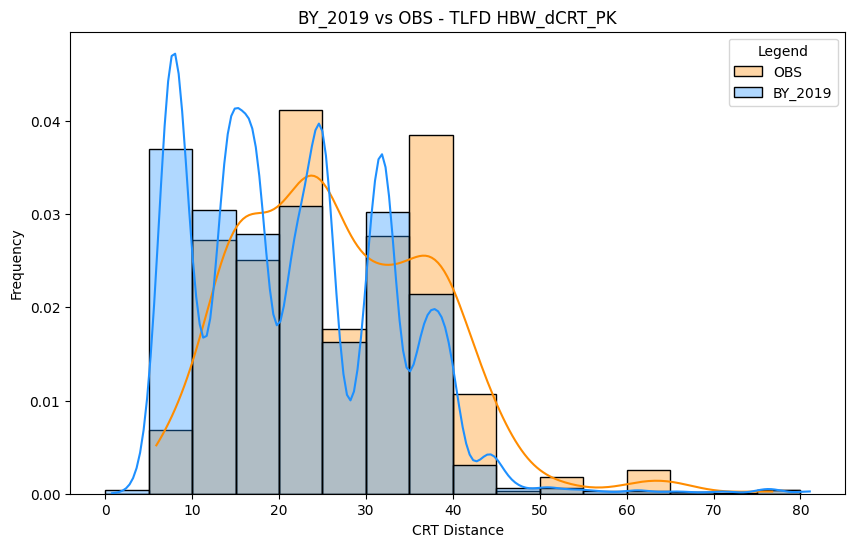

HBW PK wCRT
2
1a_Skims\skm_w8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBW_trips_allsegs_PK.omx
0.78
81.08
(825784, 4)
Contains NaN values: False
Contains Inf values: False
1973.0580999999995
output_plot_file


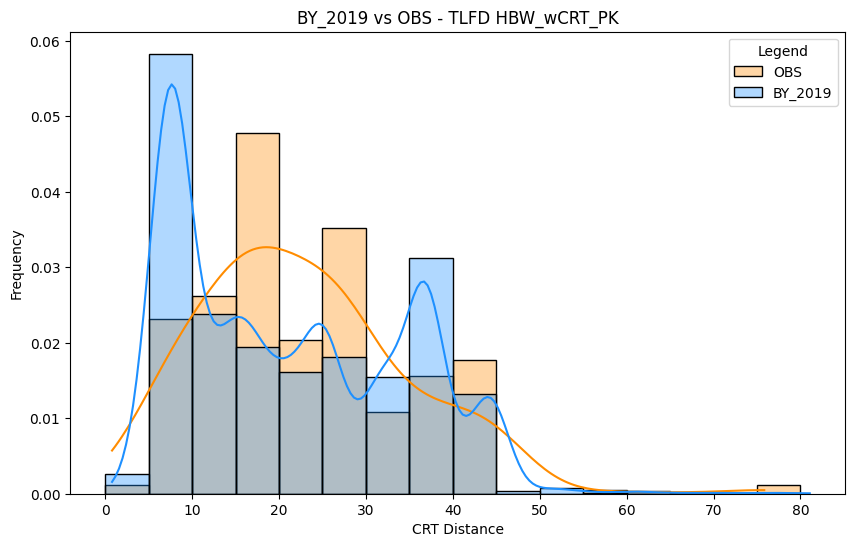

HBW OK dCRT
1
1a_Skims\skm_d8_Ok.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBW_trips_allsegs_OK.omx
0.78
81.08
(3142543, 4)
Contains NaN values: False
Contains Inf values: False
1639.966300000001
output_plot_file


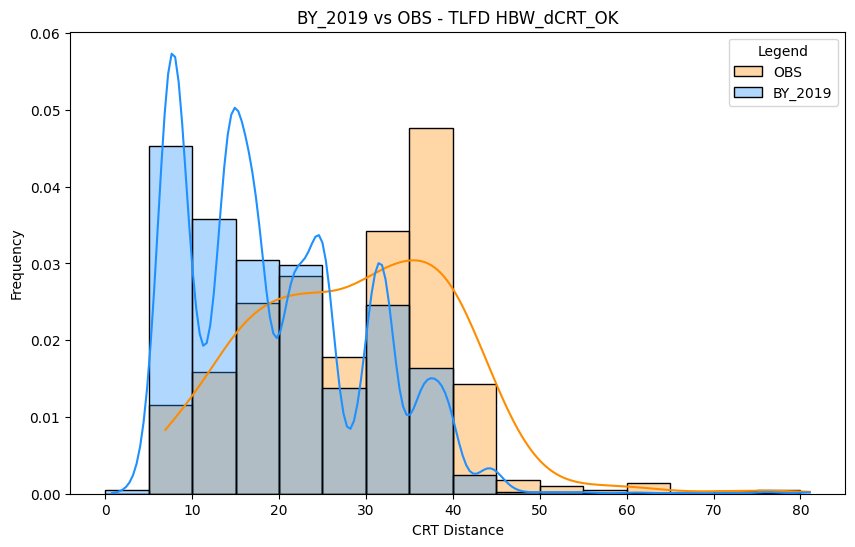

HBW OK wCRT
3
1a_Skims\skm_w8_Ok.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBW_trips_allsegs_OK.omx
0.78
81.08
(535332, 4)
Contains NaN values: False
Contains Inf values: False
822.9611000000001
output_plot_file


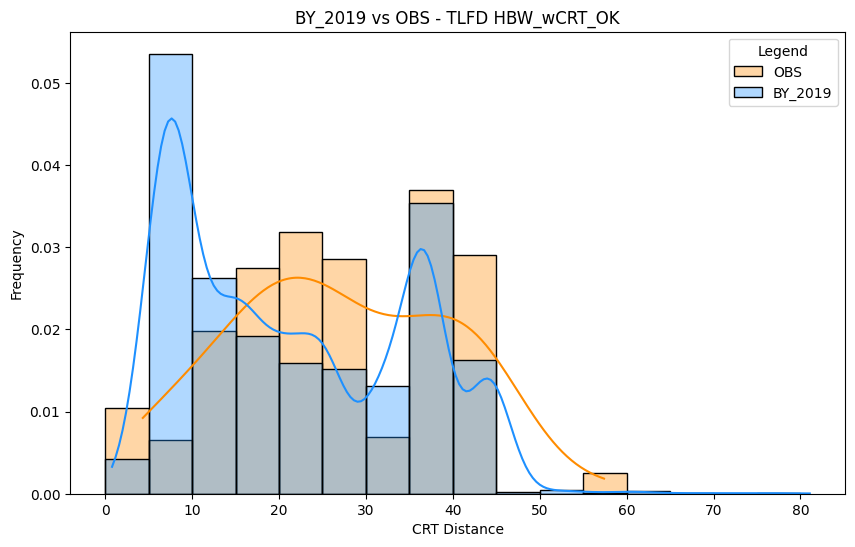

HBO PK dCRT
0
1a_Skims\skm_d8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBO_trips_allsegs_PK.omx
0.78
81.08
(3711863, 4)
Contains NaN values: False
Contains Inf values: False
1111.6544999999999
output_plot_file


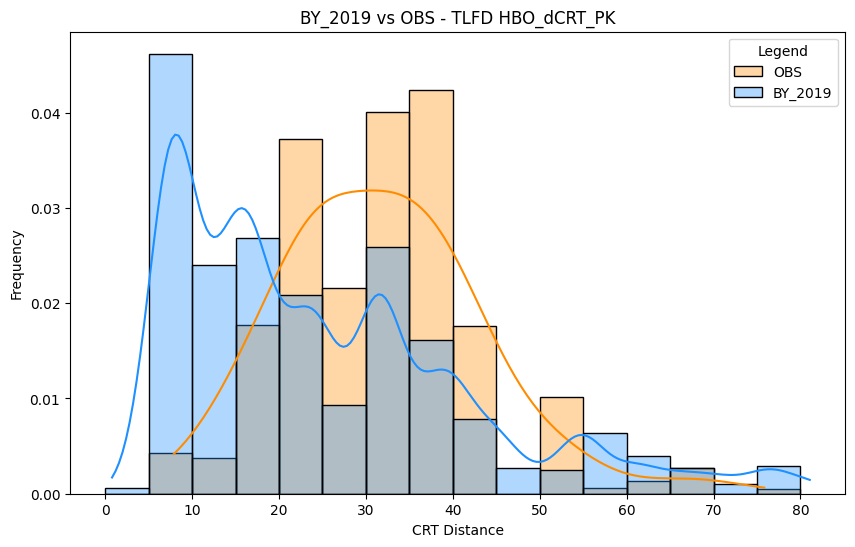

HBO PK wCRT
2
1a_Skims\skm_w8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBO_trips_allsegs_PK.omx
0.78
81.08
(825784, 4)
Contains NaN values: False
Contains Inf values: False
615.8268999999999
output_plot_file


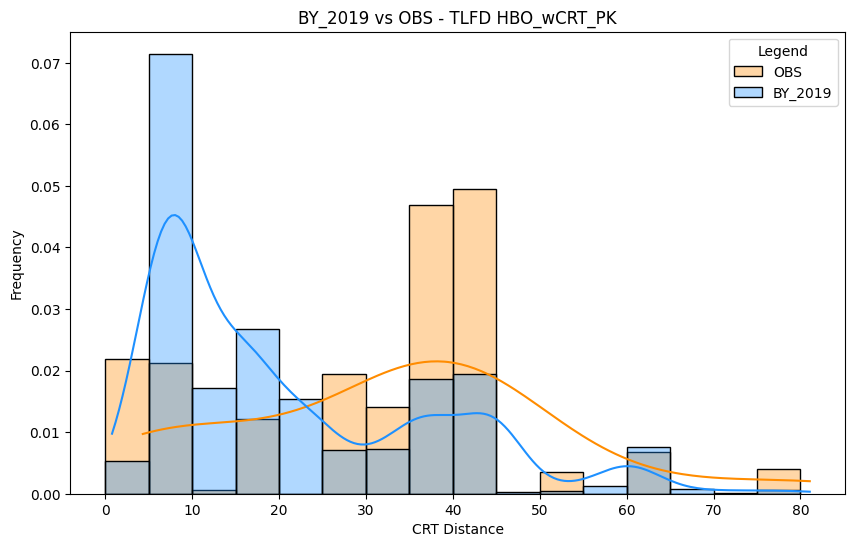

HBO OK dCRT
1
1a_Skims\skm_d8_Ok.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBO_trips_allsegs_OK.omx
0.78
81.08
(3142543, 4)
Contains NaN values: False
Contains Inf values: False
1113.126599999999
output_plot_file


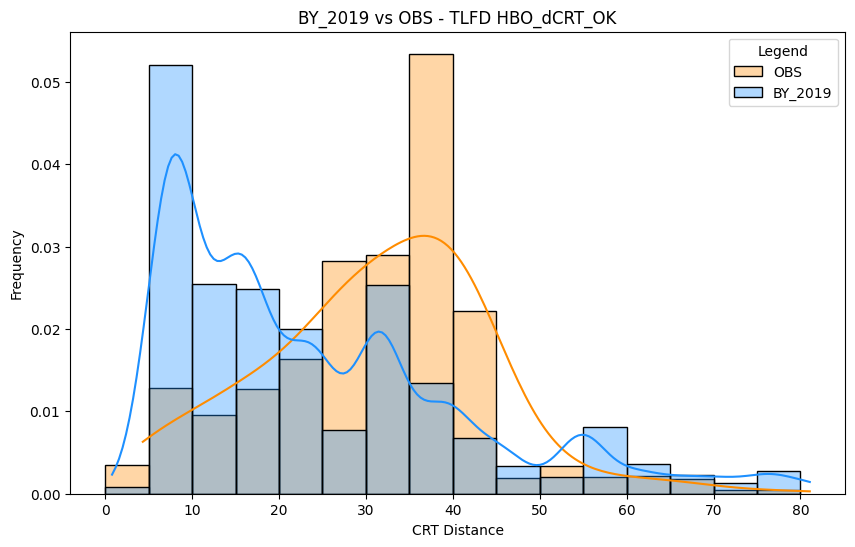

HBO OK wCRT
3
1a_Skims\skm_w8_Ok.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBO_trips_allsegs_OK.omx
0.78
81.08
(535332, 4)
Contains NaN values: False
Contains Inf values: False
1375.7346000000005
output_plot_file


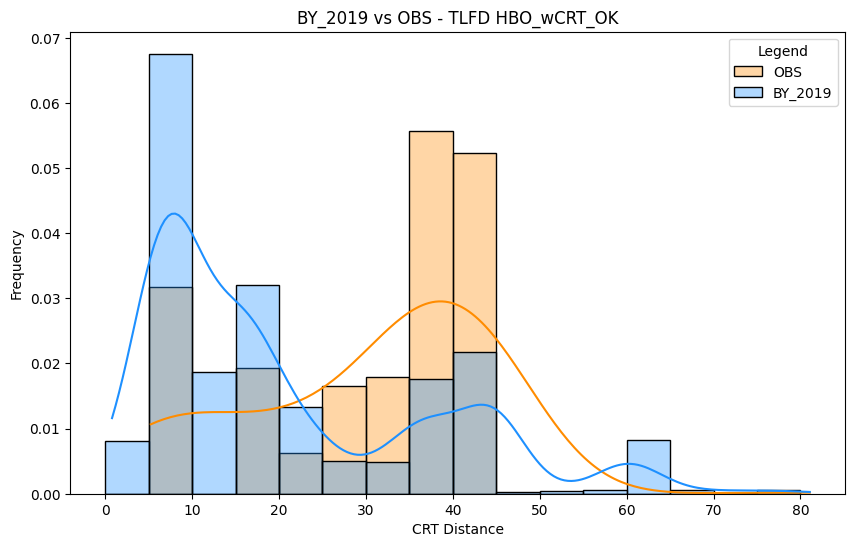

NHB PK dCRT
0
1a_Skims\skm_d8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\NHB_trips_allsegs_PK.omx
0.78
81.08
(3711863, 4)
Contains NaN values: False
Contains Inf values: False
157.73200000000014
output_plot_file


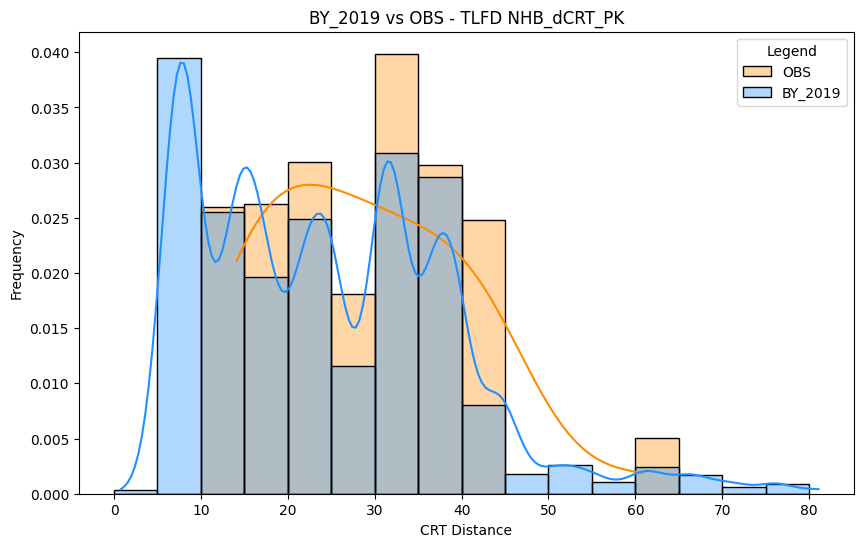

NHB PK wCRT
2
1a_Skims\skm_w8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\NHB_trips_allsegs_PK.omx
0.78
81.08
(825784, 4)
Contains NaN values: False
Contains Inf values: False
308.19949999999994
output_plot_file


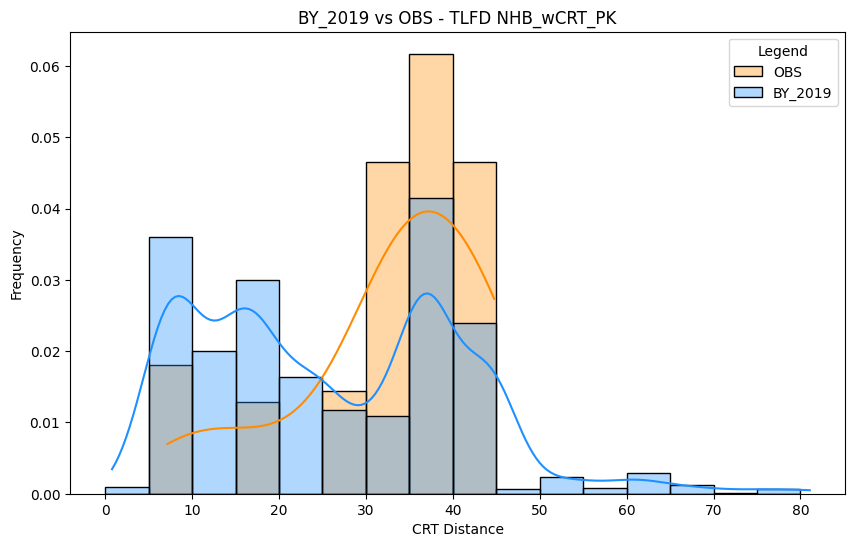

NHB OK dCRT
1
1a_Skims\skm_d8_Ok.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\NHB_trips_allsegs_OK.omx
0.78
81.08
(3142543, 4)
Contains NaN values: False
Contains Inf values: False
252.91710000000003
output_plot_file


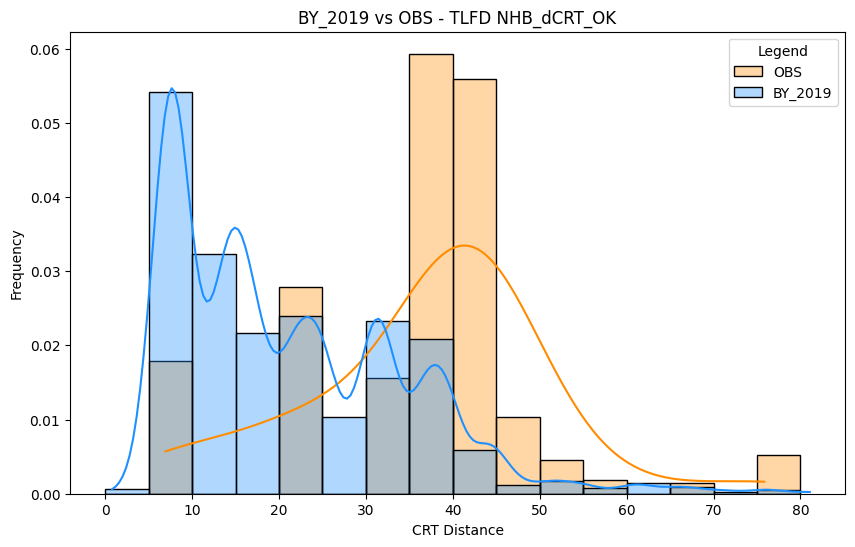

NHB OK wCRT
3
1a_Skims\skm_w8_Ok.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\NHB_trips_allsegs_OK.omx
0.78
81.08
(535332, 4)
Contains NaN values: False
Contains Inf values: False
562.6050000000002
output_plot_file


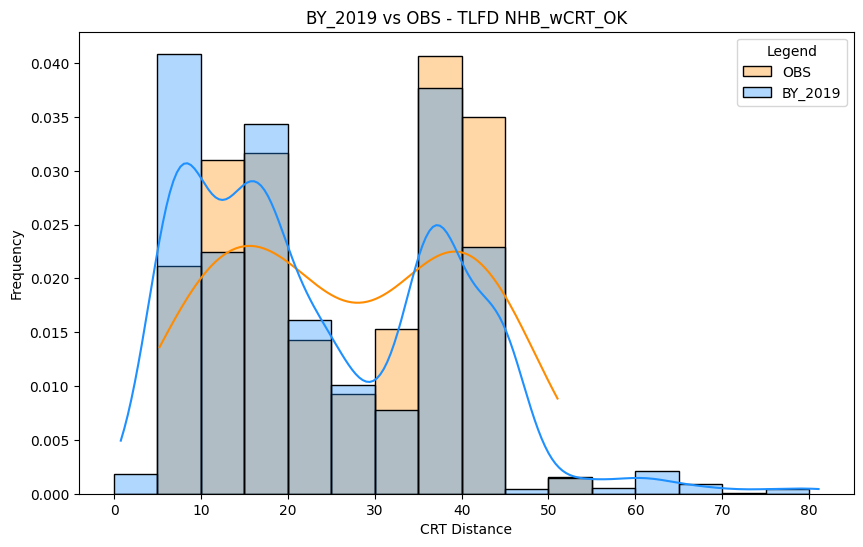

HBC PK dCRT
0
1a_Skims\skm_d8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBC_trips_allsegs_PK.omx
0.78
81.08
(3711863, 4)
Contains NaN values: False
Contains Inf values: False
2745.152699999999
output_plot_file


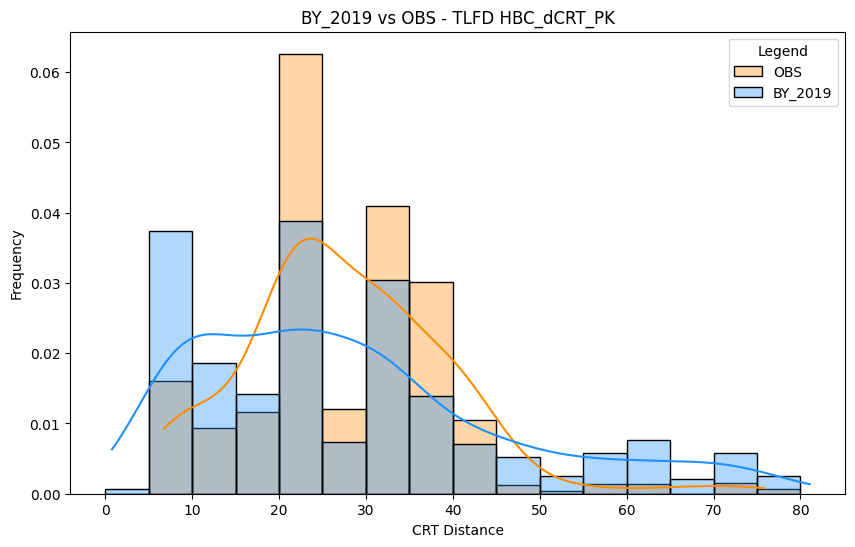

HBC PK wCRT
2
1a_Skims\skm_w8_Pk.omx
trip_fix \\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBC_trips_allsegs_PK.omx
0.78
81.08
(825784, 4)
Contains NaN values: False
Contains Inf values: False
760.5663999999998
output_plot_file


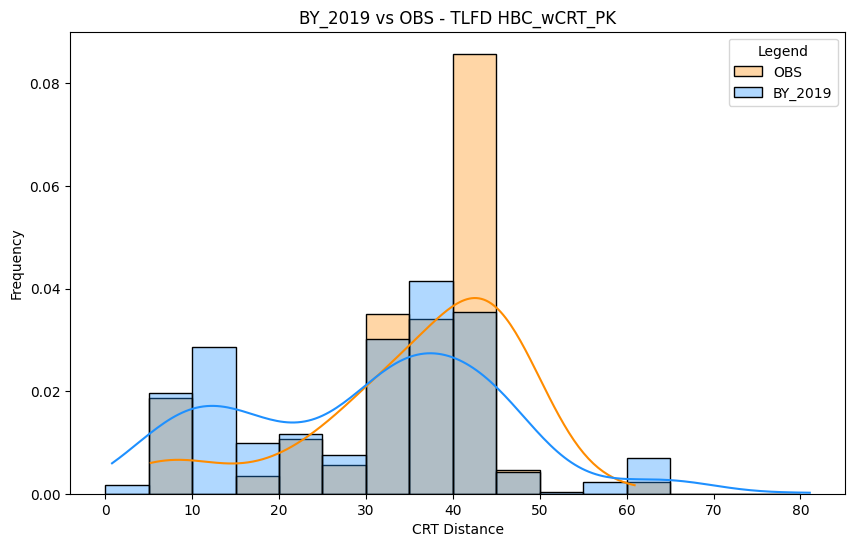

HBC OK dCRT
1
1a_Skims\skm_d8_Ok.omx


FileNotFoundError: ``\\modelace\ModelAce-E\1 - TDM\1 - Official Release (full run)\v9x\v9.1\v9.1.0\WF-TDM-v9.1.0 - official\Scenarios\BY_2019\4_ModeChoice\2_DetailedTripMatrices\HBC_trips_allsegs_OK.omx`` does not exist

In [11]:
print("Processing Scenario:")

cr_obs_df=OBS_w_Time_df.copy()

purpurses =('HBW','HBO','NHB','HBC')
periods = ('PK','OK')
accesses =('dCRT', 'wCRT')

skimloc_mapping = {
    ('PK', 'dCRT'): 0,
    ('PK', 'wCRT'): 2,
    ('OK', 'dCRT'): 1,
    ('OK', 'wCRT'): 3
}
access_mapping = {'dCRT': 'Drive', 'wCRT': 'Walk'}

# Thedata.loc[Thedata['Purp5_text'] == 'HBC', 'PK_OK'] = Thedata.loc[Thedata['Purp5_text'] == 'HBC', 'PK_OK'].replace('OK', 'PK')

for purpurse in purpurses:
    for period in periods:
        for access in accesses:

            print(purpurse,period,access)
            print(skimloc_mapping.get((period, access), None))
            print(transit_skim_loc[skimloc_mapping.get((period, access), None)])
            # model_dict = {}
            ### Read and prepare model data for four combinations
            ### 1 - drive and peak, 2 - drive and offpeak, 3 - walk and peak, 4 - walk and offpeak
            model_df = create_model_mtx_to_df(
                trips_file_name = os.path.join(model_data_loc2, '2_DetailedTripMatrices', f"{purpurse}_trips_allsegs_{period}.omx"),
                crtime_file_name=os.path.join(model_data_loc2, transit_skim_loc[skimloc_mapping.get((period, access), None)]),
                trips_mtx_name = access)

            print('trip_fix',os.path.join(model_data_loc2, '2_DetailedTripMatrices', f"{purpurse}_trips_allsegs_{period}.omx"))
            ### Merge all dataframes
            # model_df = pd.concat([model_drive_pk_df, model_drive_ok_df], axis=0) #, model_walk_pk_df, model_walk_ok_df
            model_df['trips_count'] /= 100
            model_df = model_df[model_df['cr_travel_distance']>0]

            # model_dict[scenario] = model_df.copy()
            print(model_df.cr_travel_distance.min())
            print(model_df.cr_travel_distance.max())
            ### Create a figure and axis
            print(model_df.shape)
            fig, ax = plt.subplots(figsize=(10, 6))              

            ### Plotting the weighted distance frequency distribution
            sns.histplot(
                data=cr_obs_df[
                    (cr_obs_df['cr_travel_distance'] > 0) &
                    (cr_obs_df['PK_OK'].isin([period.upper()])) &  # Fix here
                    (cr_obs_df['Ac_Mode_Model'].isin([access_mapping.get(access, 'Unknown')])) &
                    (cr_obs_df['Purp5_text'].isin([purpurse]))],x='cr_travel_distance', 
                weights='linked_weight_adj', 
                bins=range(int(model_df['cr_travel_distance'].min()), int(model_df['cr_travel_distance'].max()) + 2, 5), 
                stat='density',
                ax=ax, 
                kde=True,
                color='darkorange',
                label='OBS',
                alpha=0.35)
            
            has_nan = model_df['cr_travel_distance'].isna().any()
            print(f"Contains NaN values: {has_nan}")

            # Check for Inf values
            has_inf = np.isinf(model_df['cr_travel_distance']).any()
            print(f"Contains Inf values: {has_inf}")

            print(model_df.trips_count.sum())
            sns.histplot(
                data=model_df, 
                x='cr_travel_distance', 
                weights='trips_count', 
                bins=range(int(model_df['cr_travel_distance'].min()), int(model_df['cr_travel_distance'].max()) + 2, 5), 
                stat='density',
                ax=ax, 
                kde=True,
                color='dodgerblue',
                label=scenario,
                alpha=0.35)

            ### Adding labels and title
            ax.set_xlabel('CRT Distance')
            ax.set_ylabel('Frequency')
            ax.set_title(scenario + ' vs OBS - TLFD' + f' {purpurse}_{access}_{period}')

            ### Adding legend
            ax.legend(title='Legend')

            ### Display the plot
            print('output_plot_file')
            plt.savefig(f'TLF_OBS_TDM_{purpurse}_{access}_{period}.png')
            plt.show()

total weights:  20314.837
output_plot_file


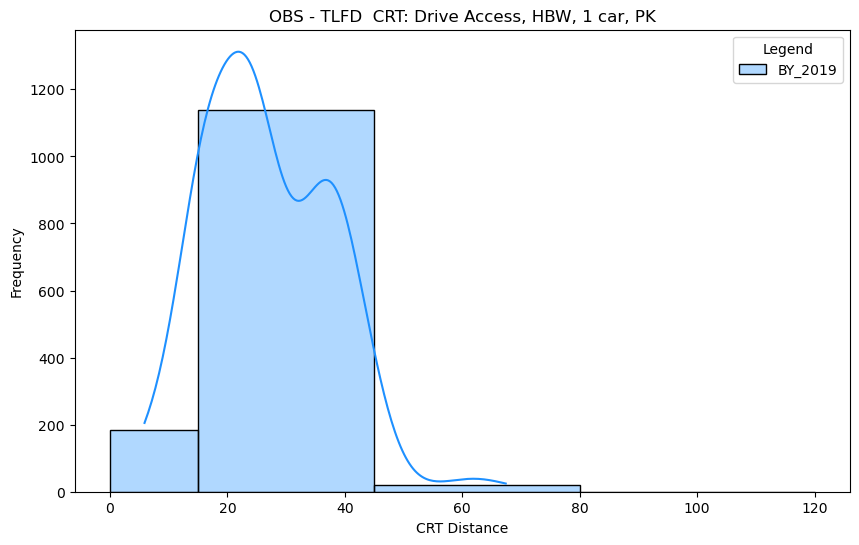

cr_travel_distance
(0, 15]       184.501
(15, 45]     1137.719
(45, 80]       21.295
(80, 120]       0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


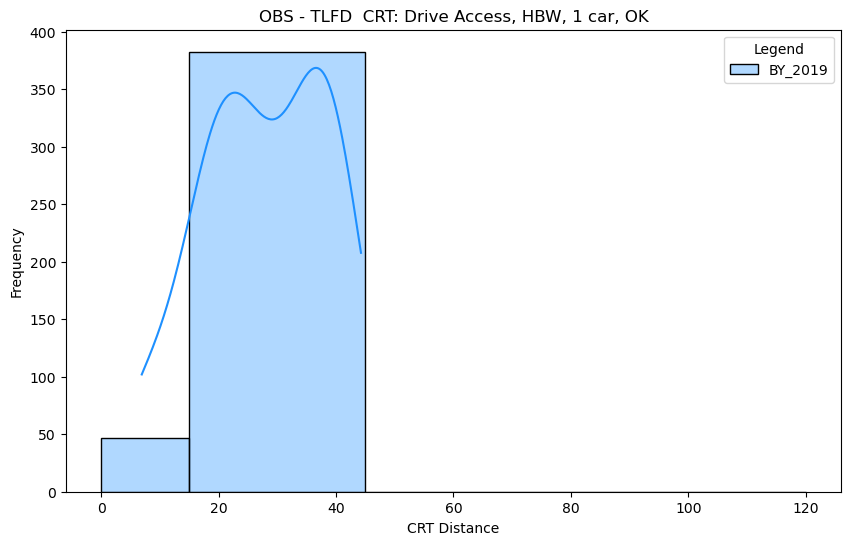

cr_travel_distance
(0, 15]       46.360
(15, 45]     382.442
(45, 80]       0.000
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


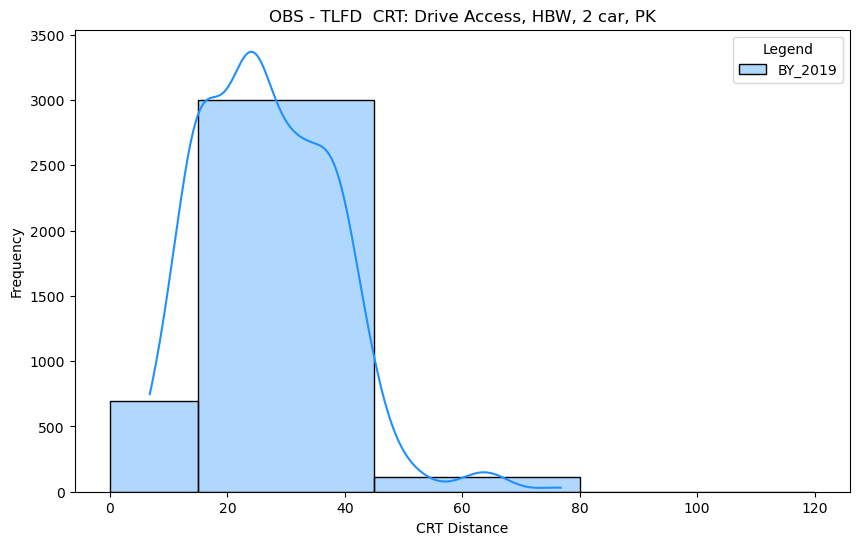

cr_travel_distance
(0, 15]       695.514
(15, 45]     3001.775
(45, 80]      115.952
(80, 120]       0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


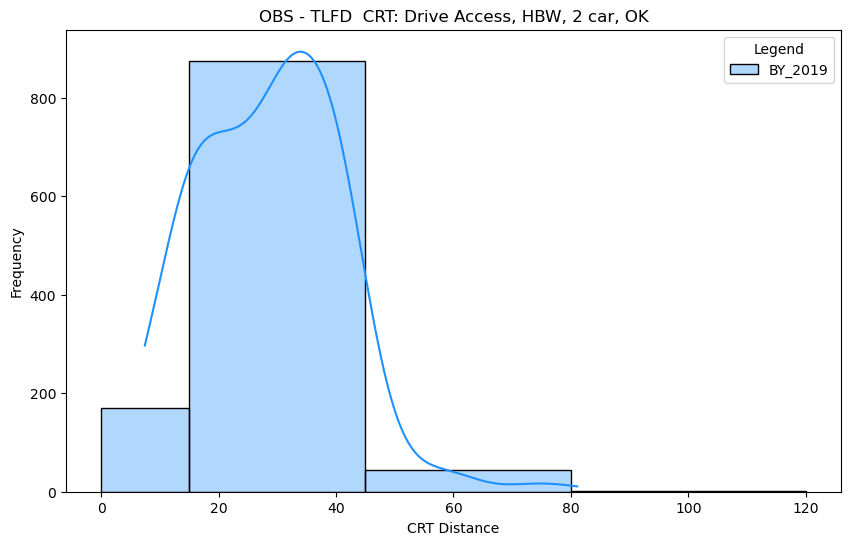

cr_travel_distance
(0, 15]      169.169
(15, 45]     875.440
(45, 80]      43.680
(80, 120]      2.111
Name: linked_weight_adj, dtype: float64
output_plot_file


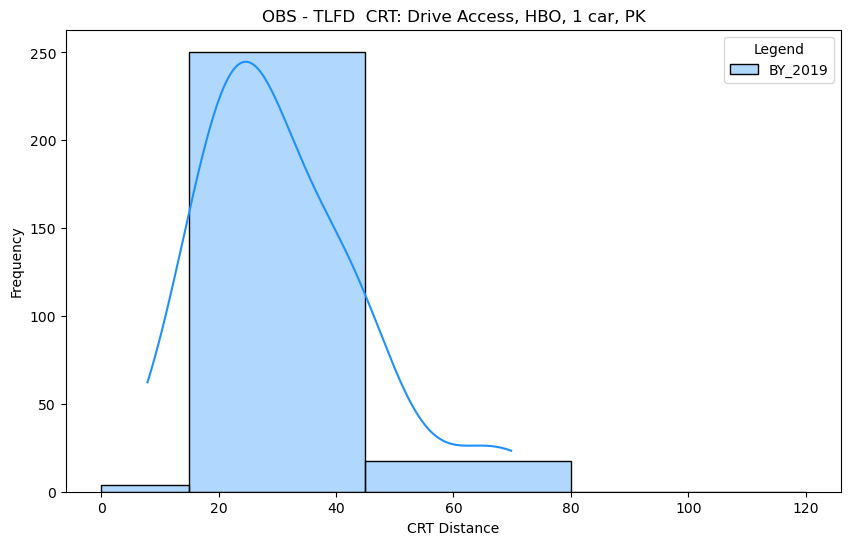

cr_travel_distance
(0, 15]        3.818
(15, 45]     250.407
(45, 80]      17.600
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


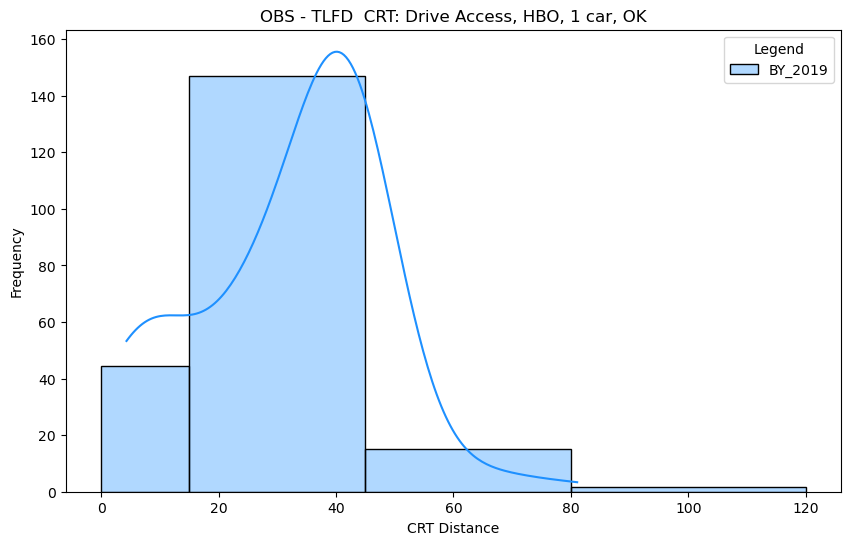

cr_travel_distance
(0, 15]       44.464
(15, 45]     146.978
(45, 80]      14.980
(80, 120]      1.749
Name: linked_weight_adj, dtype: float64
output_plot_file


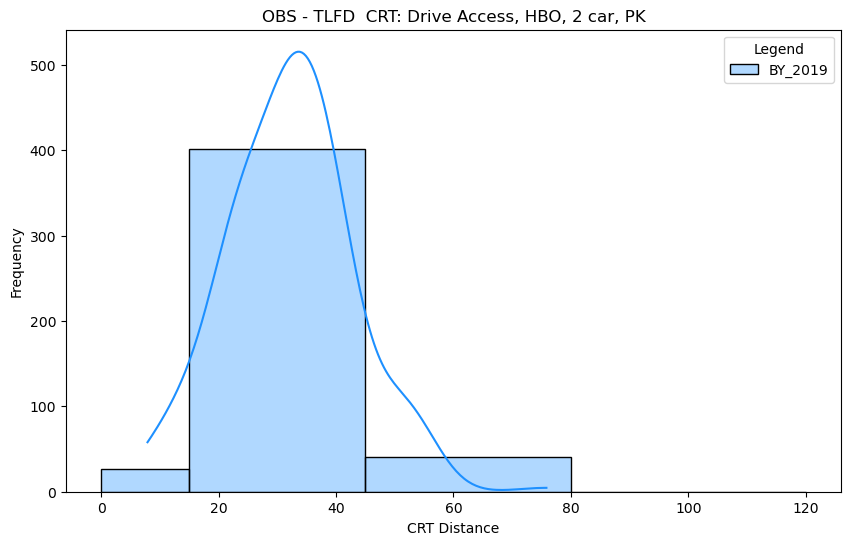

cr_travel_distance
(0, 15]       26.906
(15, 45]     401.099
(45, 80]      40.887
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


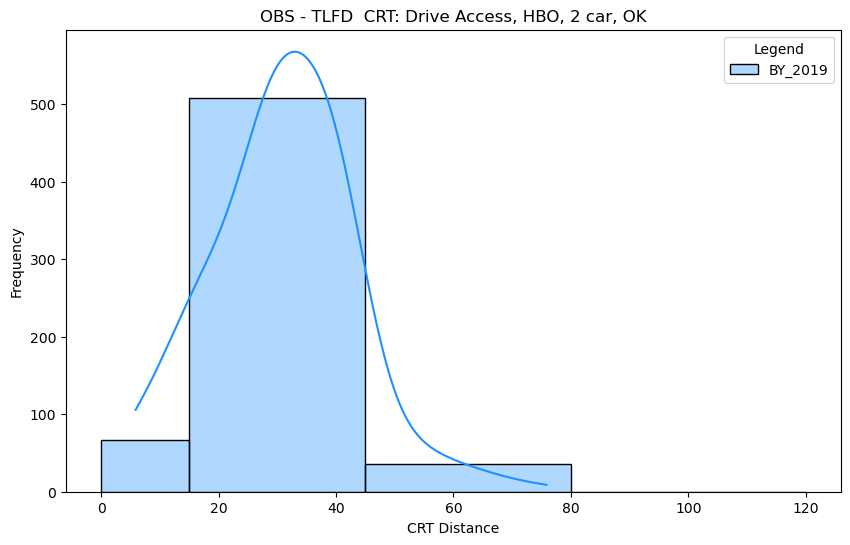

cr_travel_distance
(0, 15]       66.313
(15, 45]     507.242
(45, 80]      36.269
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


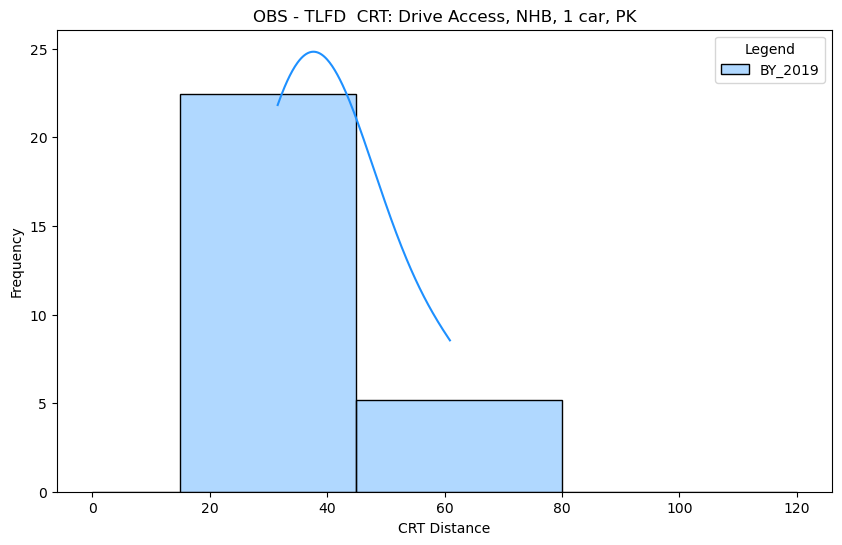

cr_travel_distance
(0, 15]       0.000
(15, 45]     22.456
(45, 80]      5.194
(80, 120]     0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


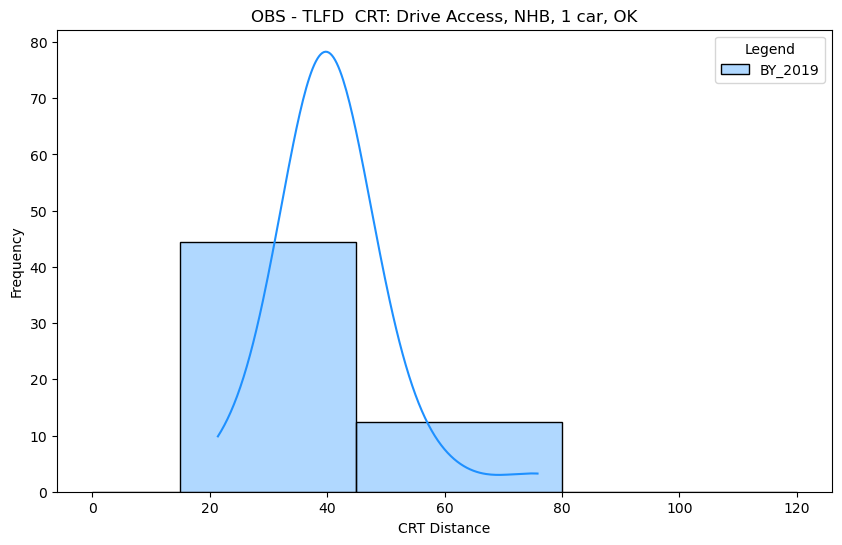

cr_travel_distance
(0, 15]       0.000
(15, 45]     44.490
(45, 80]     12.332
(80, 120]     0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


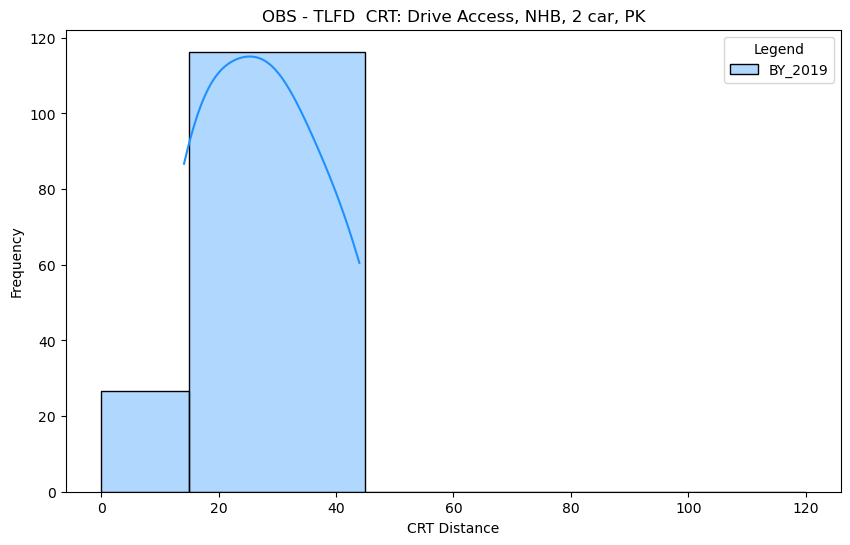

cr_travel_distance
(0, 15]       26.527
(15, 45]     116.309
(45, 80]       0.000
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


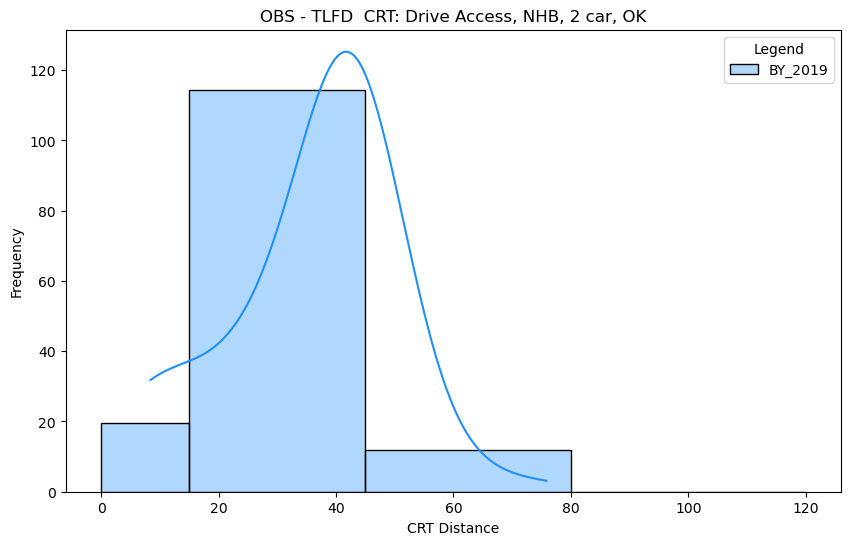

cr_travel_distance
(0, 15]       19.557
(15, 45]     114.461
(45, 80]      11.768
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


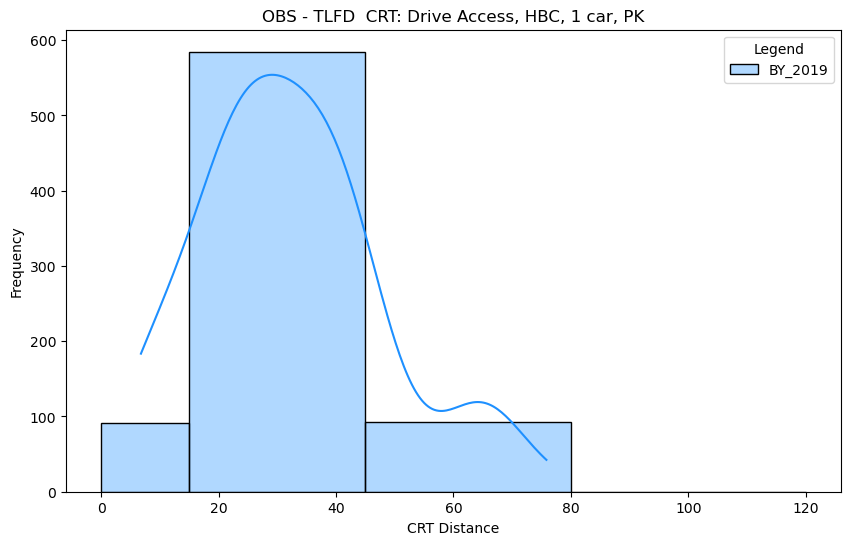

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cr_travel_distance
(0, 15]       91.949
(15, 45]     584.718
(45, 80]      92.798
(80, 120]      0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


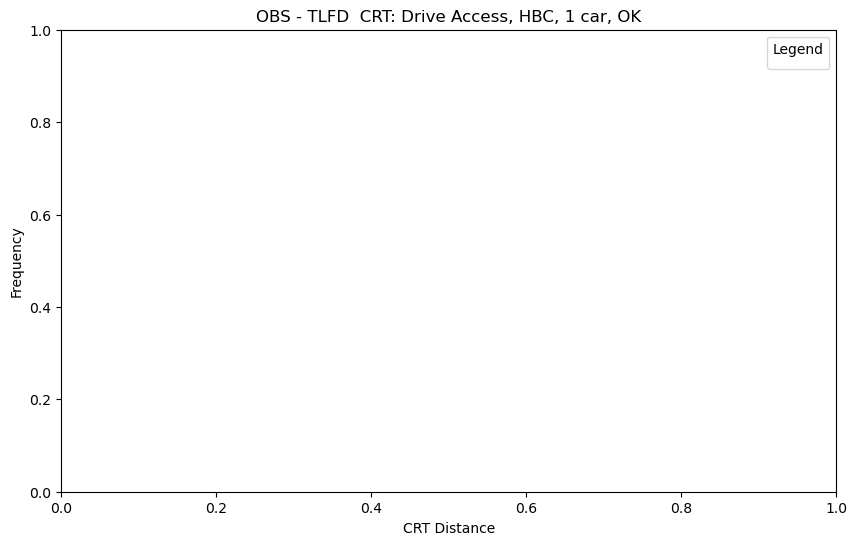

cr_travel_distance
(0, 15]      0.0
(15, 45]     0.0
(45, 80]     0.0
(80, 120]    0.0
Name: linked_weight_adj, dtype: float64
output_plot_file


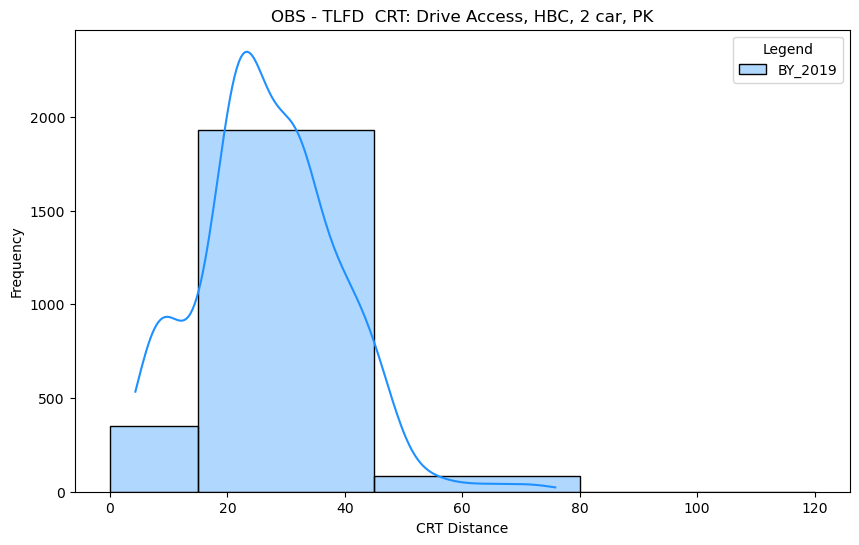

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cr_travel_distance
(0, 15]       351.479
(15, 45]     1928.452
(45, 80]       85.646
(80, 120]       0.000
Name: linked_weight_adj, dtype: float64
output_plot_file


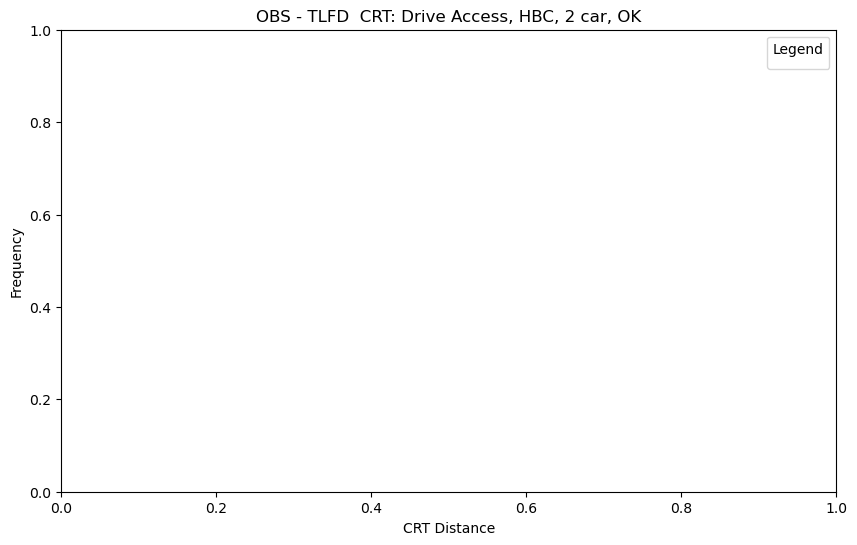

cr_travel_distance
(0, 15]      0.0
(15, 45]     0.0
(45, 80]     0.0
(80, 120]    0.0
Name: linked_weight_adj, dtype: float64


In [184]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print('total weights: ',cr_obs_df.linked_weight_adj.sum())
purpurses =('HBW','HBO','NHB','HBC')
cars = (1,2)
periods = ('PK', 'OK')

Thedata = cr_obs_df.copy()
Thedata.loc[Thedata['Purp5_text'] == 'HBC', 'PK_OK'] = Thedata.loc[Thedata['Purp5_text'] == 'HBC', 'PK_OK'].replace('OK', 'PK')

for purpurse in purpurses:
    for car in cars:
        for period in periods:
            Thisdata=Thedata[(Thedata['cr_travel_distance']>0) & (Thedata['PK_OK'].isin([period])) & (Thedata['Ac_Mode_Model'].isin(['Drive'])) & (Thedata['Veh_Cat3p'].isin([car])) & (Thedata['Purp5_text'].isin([purpurse]))]
            
            # Define custom bins for your histogram
            bin_edges = [0, 15, 45, 80, 120]  # Example bins

            # Plotting the histogram
            fig, ax = plt.subplots(figsize=(10, 6))

            sns.histplot(
                data=Thisdata, 
                x='cr_travel_distance', 
                weights='linked_weight_adj', 
                bins=bin_edges,  # Using custom bins
                stat='count',
                ax=ax, 
                kde=True,
                color='dodgerblue',
                label=scenario,
                alpha=0.35
            )

            # Adding labels and title
            ax.set_xlabel('CRT Distance')
            ax.set_ylabel('Frequency')
            ax.set_title('OBS - TLFD ' + ' CRT: Drive Access, '+str(purpurse)+', '+str(car) + ' car, '+ str(period))

            # Adding legend
            ax.legend(title='Legend')

            # Display the plot
            print('output_plot_file')
            plt.savefig(f'OBS_TLF_{purpurse}_{car} car_{period}.png')
            plt.show()

            # Calculate the counts in each bin and create a DataFrame
            # Create bins
            # Bin the 'cr_travel_distance' column
            hist_data = pd.cut(Thisdata['cr_travel_distance'], bins=bin_edges)

            # Sum the weights ('linked_weight_adj') within each bin
            bin_sums = Thisdata.groupby(hist_data)['linked_weight_adj'].sum()

            # If you want to see the sum for each bin
            print(bin_sums)


            # Convert the counts to a DataFrame and export to CSV
            bin_counts_df = bin_sums.reset_index()
            bin_counts_df.columns = ['CRT_Distance_Range', 'Frequency']

            # Export to CSV
            bin_counts_df.to_csv(f'CRT_travel_Distance_histogram_Dcrt_{purpurse}_{car}_car_{period}.csv', index=False)


output_plot_file


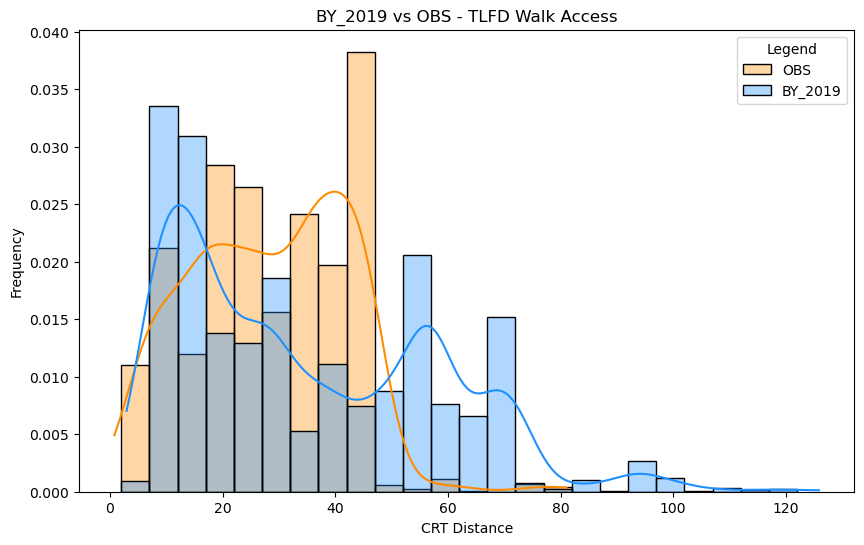

In [118]:

### Merge all dataframes
model_df = pd.concat([model_walk_pk_df, model_walk_ok_df], axis=0) #, model_walk_pk_df, model_walk_ok_df
model_df['trips_count'] /= 100
model_df = model_df[model_df['cr_travel_time']>0]

model_dict[scenario] = model_df.copy()

### Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

### Plotting the weighted distance frequency distribution
sns.histplot(
    data=cr_obs_df[(cr_obs_df['cr_travel_time']>0) & (cr_obs_df['PK_OK'].isin(['PK','OK'])) & (cr_obs_df['Ac_Mode_Model'].isin(['Walk']))], 
    x='cr_travel_time', 
    weights='linked_weight_adj', 
    bins=range(int(model_df['cr_travel_time'].min()), int(model_df['cr_travel_time'].max()) + 2, 5), 
    stat='density',
    ax=ax, 
    kde=True,
    color='darkorange',
    label='OBS',
    alpha=0.35)

sns.histplot(
    data=model_df, 
    x='cr_travel_time', 
    weights='trips_count', 
    bins=range(int(model_df['cr_travel_time'].min()), int(model_df['cr_travel_time'].max()) + 2, 5), 
    stat='density',
    ax=ax, 
    kde=True,
    color='dodgerblue',
    label=scenario,
    alpha=0.35)

### Adding labels and title
ax.set_xlabel('CRT Distance')
ax.set_ylabel('Frequency')
ax.set_title(scenario + ' vs OBS - TLFD' + ' Walk Access')

### Adding legend
ax.legend(title='Legend')

### Display the plot
print('output_plot_file')
plt.savefig('TLF_OBS_TDM.png')
plt.show()